# RGPs

In this notebook, we'll explore the database for regions of genomic plasticity. In Mathee et al., RGPs are defined as regions of at least four contiguous open reading frames (ORFs) that are not present in all compared genomes. If the two ORFs neighbouring the RGP (one on each side) are conserved in all strains, they are marked as anchors.

We'll try to develop a cypher query that is able to retrieve regions complying to this definition. 

First look for anchors: two clusters that are neighbouring each other in the majority of the strains. Then check the paths in the strains where they are not neighbouring, and check whether an insertion happened (a limited number of ORFs inbetween).

In this notebook, we can retrieve all such 'insertional paths'. We can then check whether there are mobile genes in them, by checking their annotations. Furthermore, we can look at the nucleotide statistics, and a neighbouring tRNA.

## Imports

In [1]:
# Imports

import neo4j
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import colourmap as colourmap

sys.path.append('./04_neo4jAPI')
import neo4jConnection

from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
from statistics import mean, stdev
from scipy.stats import ttest_ind_from_stats
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from Bio import Phylo

In case insertions have already been retrieved and saved to CSV, run the following code:

In [2]:
possibleRGPs = pd.read_csv('insertions.csv', sep='\t')
possibleRGPs['InsertionListGC'] = possibleRGPs['InsertionListGC'].apply(eval)
possibleRGPs['InsertionListCAI'] = possibleRGPs['InsertionListCAI'].apply(eval)
possibleRGPs['InsertionListClusterID'] = possibleRGPs['InsertionListClusterID'].apply(eval)
possibleRGPs['InsertionListMobileNames'] = possibleRGPs['InsertionListMobileNames'].apply(eval)
possibleRGPs

,StrainName,StrainAvgGC,StrainStDevGC,StrainAvgCAI,StrainStDevCAI,Anchor1ID,Anchor2ID,InsertionStart,InsertionEnd,InsertionNbFeatures,InsertionListGC,InsertionListCAI,InsertionListClusterID,InsertionListMobileNames,InsertionNbTRNAs
0,GCF_014217315_1,66.214825,4.657828,0.341129,0.063668,g000678_2_000008,g003919_000004,3365906,3410929,45,"[63.41085271317829, None, 61.30952380952381, 6...","[0.3269846777152484, None, 0.2073067106778974,...","[g000678_2_000008, g000250_000002, g000441_000...",[site-specific integrase],0
1,GCF_011106815_1,65.478170,5.314672,0.335514,0.066259,g000678_2_000008,g003919_000004,3423947,3442921,11,"[63.41085271317829, 60.22155085599194, 62.0689...","[0.3269846777152484, 0.26767908277728586, 0.24...","[g000678_2_000008, g000250_000002, g000441_000...",[site-specific integrase],0
2,GCF_013394455_1,66.388103,4.426239,0.342270,0.062392,g000678_2_000008,g003919_000004,3212037,3231011,11,"[63.41085271317829, None, 62.06896551724138, 5...","[0.3269846777152484, None, 0.24183448799933907...","[g000678_2_000008, g000250_000002, g000441_000...",[site-specific integrase],0
3,GCA_013394455_1,66.384190,4.425339,0.341914,0.062808,g000678_2_000008,g003919_000004,3212037,3231011,12,"[63.41085271317829, None, 62.06896551724138, N...","[0.3269846777152484, None, 0.24183448799933907...","[g000678_2_000008, g000250_000002, g000441_000...",[tyrosine-type recombinase/integrase],0
4,GCA_011106815_1,65.405187,5.404381,0.331841,0.069854,g000678_2_000008,g003919_000004,3423947,3442921,12,"[63.41085271317829, None, 62.06896551724138, N...","[0.3269846777152484, None, 0.24183448799933907...","[g000678_2_000008, g000250_000002, g000441_000...",[tyrosine-type recombinase/integrase],0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5073,GCF_000829885_1,66.149134,4.667077,0.341211,0.063279,g005328_000004,g003785_2_000014,2122206,2289881,169,"[71.80156657963447, 66.66666666666667, 69.8879...","[0.31192330740984975, 0.31306132102455947, 0.4...","[g005328_000004, g001674_1_000006, g003495_000...",[IS110-like element ISPa11 family transposase],7
5074,GCF_002085605_1,65.634515,5.033900,0.333222,0.066075,g005328_000004,g003785_2_000014,5047356,5225304,180,"[71.80156657963447, 66.66666666666667, 69.8879...","[0.31192330740984975, 0.31687805417253007, 0.4...","[g005328_000004, g001674_1_000006, g003495_000...",[IS110-like element ISPa11 family transposase],7
5075,GCF_004193735_1,65.907861,5.032003,0.338294,0.064448,g005328_000004,g003785_2_000014,1921229,2088911,170,"[71.54046997389034, 66.46706586826348, 70.0280...","[0.30475917265722813, 0.31789385686915406, 0.4...","[g005328_000004, g001674_1_000006, g003495_000...",[IS110-like element ISPa11 family transposase],7
5076,GCF_001516345_1,66.218843,4.471416,0.339890,0.063529,g006881_000004,g000867_1_000014,1974828,1989197,12,"[None, 47.740112994350284, 52.88065843621399, ...","[None, 0.23763819153460314, 0.2518901325338301...","[g006881_000004, g000867_1_000014, g013433_000...","[IS21 family transposase, tyrosine-type recomb...",0


## Connection with database

In [11]:
# neo4j connection

uri = 'bolt://localhost:7687' # fill in correct uri
user = 'neo4j'
pwd = '770strains' # fill in correct password
connection = neo4jConnection.Connection(uri, user, pwd)
driver = connection.getDriver()

## Retrieve possible RGPs

In [11]:
def getPossibleRGPs_work(tx: neo4j.Session) -> neo4j.Result:
    result = tx.run("""
        match (c1:CLUSTER)-[r:NEIGHBOUR]-(c2:CLUSTER)
        where c1.number_genomes > 0.95*770 and c2.number_genomes > 0.95*770

        // count the number of outgoing relations from c1
        with 
            ([(c1)-[n:NEIGHBOUR]->(:CLUSTER)|n.number_of_members]) 
            as nb_per_outgoing_rel, c1, r, c2
        with 
            reduce(total =0, int in nb_per_outgoing_rel | total + int) 
            as nb_out, c1, r, c2
            
        WHERE 0.7*nb_out <  r.number_of_members and c1 <> c2
        match (strain:STRAIN)
        match (strain)--(f1:FEATURE)--(c1), (strain)--(f2:FEATURE)--(c2)
        match path = (f1)-[:NEIGHBOUR*5..200]->(f2)
        where any(node in nodes(path) where node.name contains 'integrase' or node.name contains 'transposase')
        CALL {
            with path
            unwind nodes(path) as InsertionFeature 
            match (InsertionCluster:CLUSTER)<-[:ORTHOLOG]-(InsertionFeature)
            return collect(InsertionCluster.cluster_id) as InsertionListClusterID
        }
        return
            strain.name as StrainName,
            strain.avg_GC as StrainAvgGC,
            strain.stDev_GC as StrainStDevGC,
            strain.avg_CAI as StrainAvgCAI,
            strain.stDev_CAI as StrainStDevCAI,
            c1.cluster_id as Anchor1ID,
            c2.cluster_id as Anchor2ID,
            nodes(path)[1].feature_start as InsertionStart,
            nodes(path)[-2].feature_end as InsertionEnd,
            length(path)-2 as InsertionNbFeatures,
            [feature in nodes(path)[1..-1] | feature.GC ] as InsertionListGC,
            [feature in nodes(path)[1..-1] | feature.CAI ] as InsertionListCAI,
            InsertionListClusterID,
            [feature in nodes(path) where feature.name contains 'integrase' or feature.name contains 'transposase'|feature.name] as InsertionListMobileNames,
            size([feature in nodes(path) where feature.feature_type = 'tRNA']) as InsertionNbTRNAs
        """)

    return result.values('StrainName', 'StrainAvgGC', 'StrainStDevGC', 'StrainAvgCAI', 'StrainStDevCAI', 
            'Anchor1ID', 'Anchor2ID', 'InsertionStart', 'InsertionEnd', 'InsertionNbFeatures', 
            'InsertionListGC', 'InsertionListCAI', 'InsertionListClusterID', 'InsertionListMobileNames', 'InsertionNbTRNAs')

def getPossibleRGPs(driver: neo4j.Driver):
    possibleRGPs_dict = {'StrainName': [], 'StrainAvgGC': [], 'StrainStDevGC': [], 'StrainAvgCAI': [], 'StrainStDevCAI': [], 
            'Anchor1ID': [], 'Anchor2ID': [], 'InsertionStart': [], 'InsertionEnd': [], 'InsertionNbFeatures': [], 
            'InsertionListGC': [], 'InsertionListCAI': [], 'InsertionListClusterID': [], 'InsertionListMobileNames': [], 
            'InsertionNbTRNAs': []}
    with driver.session() as session:
        result = session.read_transaction(getPossibleRGPs_work)
        for record in result:
            [StrainName, StrainAvgGC, StrainStDevGC, StrainAvgCAI, StrainStDevCAI,
            Anchor1ID, Anchor2ID, InsertionStart, InsertionEnd, InsertionNbFeatures,
            InsertionListGC, InsertionListCAI, InsertionListClusterID, InsertionListMobileNames, InsertionNbTRNAs] = record
            possibleRGPs_dict['StrainName'].append(StrainName)
            possibleRGPs_dict['StrainAvgGC'].append(StrainAvgGC)
            possibleRGPs_dict['StrainStDevGC'].append(StrainStDevGC)
            possibleRGPs_dict['StrainAvgCAI'].append(StrainAvgCAI)
            possibleRGPs_dict['StrainStDevCAI'].append(StrainStDevCAI)
            possibleRGPs_dict['Anchor1ID'].append(Anchor1ID)
            possibleRGPs_dict['Anchor2ID'].append(Anchor2ID)
            possibleRGPs_dict['InsertionStart'].append(InsertionStart)
            possibleRGPs_dict['InsertionEnd'].append(InsertionEnd)
            possibleRGPs_dict['InsertionNbFeatures'].append(InsertionNbFeatures)
            possibleRGPs_dict['InsertionListGC'].append(InsertionListGC)
            possibleRGPs_dict['InsertionListCAI'].append(InsertionListCAI)
            possibleRGPs_dict['InsertionListClusterID'].append(InsertionListClusterID)
            possibleRGPs_dict['InsertionListMobileNames'].append(InsertionListMobileNames)
            possibleRGPs_dict['InsertionNbTRNAs'].append(InsertionNbTRNAs)
    return pd.DataFrame.from_dict(possibleRGPs_dict)

In [12]:
possibleRGPs = getPossibleRGPs(driver)
possibleRGPs

,StrainName,StrainAvgGC,StrainStDevGC,StrainAvgCAI,StrainStDevCAI,Anchor1ID,Anchor2ID,InsertionStart,InsertionEnd,InsertionNbFeatures,InsertionListGC,InsertionListCAI,InsertionListClusterID,InsertionListMobileNames,InsertionNbTRNAs
0,GCF_014217315_1,66.214825,4.657828,0.341129,0.063668,g000678_2_000008,g003919_000004,3365906,3410929,45,"[63.41085271317829, None, 61.30952380952381, 6...","[0.3269846777152484, None, 0.2073067106778974,...","[g000678_2_000008, g000250_000002, g000441_000...",[site-specific integrase],0
1,GCF_011106815_1,65.478170,5.314672,0.335514,0.066259,g000678_2_000008,g003919_000004,3423947,3442921,11,"[63.41085271317829, 60.22155085599194, 62.0689...","[0.3269846777152484, 0.26767908277728586, 0.24...","[g000678_2_000008, g000250_000002, g000441_000...",[site-specific integrase],0
2,GCF_013394455_1,66.388103,4.426239,0.342270,0.062392,g000678_2_000008,g003919_000004,3212037,3231011,11,"[63.41085271317829, None, 62.06896551724138, 5...","[0.3269846777152484, None, 0.24183448799933907...","[g000678_2_000008, g000250_000002, g000441_000...",[site-specific integrase],0
3,GCA_013394455_1,66.384190,4.425339,0.341914,0.062808,g000678_2_000008,g003919_000004,3212037,3231011,12,"[63.41085271317829, None, 62.06896551724138, N...","[0.3269846777152484, None, 0.24183448799933907...","[g000678_2_000008, g000250_000002, g000441_000...",[tyrosine-type recombinase/integrase],0
4,GCA_011106815_1,65.405187,5.404381,0.331841,0.069854,g000678_2_000008,g003919_000004,3423947,3442921,12,"[63.41085271317829, None, 62.06896551724138, N...","[0.3269846777152484, None, 0.24183448799933907...","[g000678_2_000008, g000250_000002, g000441_000...",[tyrosine-type recombinase/integrase],0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5073,GCF_000829885_1,66.149134,4.667077,0.341211,0.063279,g005328_000004,g003785_2_000014,2122206,2289881,169,"[71.80156657963447, 66.66666666666667, 69.8879...","[0.31192330740984975, 0.31306132102455947, 0.4...","[g005328_000004, g001674_1_000006, g003495_000...",[IS110-like element ISPa11 family transposase],7
5074,GCF_002085605_1,65.634515,5.033900,0.333222,0.066075,g005328_000004,g003785_2_000014,5047356,5225304,180,"[71.80156657963447, 66.66666666666667, 69.8879...","[0.31192330740984975, 0.31687805417253007, 0.4...","[g005328_000004, g001674_1_000006, g003495_000...",[IS110-like element ISPa11 family transposase],7
5075,GCF_004193735_1,65.907861,5.032003,0.338294,0.064448,g005328_000004,g003785_2_000014,1921229,2088911,170,"[71.54046997389034, 66.46706586826348, 70.0280...","[0.30475917265722813, 0.31789385686915406, 0.4...","[g005328_000004, g001674_1_000006, g003495_000...",[IS110-like element ISPa11 family transposase],7
5076,GCF_001516345_1,66.218843,4.471416,0.339890,0.063529,g006881_000004,g000867_1_000014,1974828,1989197,12,"[None, 47.740112994350284, 52.88065843621399, ...","[None, 0.23763819153460314, 0.2518901325338301...","[g006881_000004, g000867_1_000014, g013433_000...","[IS21 family transposase, tyrosine-type recomb...",0


In [13]:
possibleRGPs.to_csv('insertions.csv',index=False, sep='\t')

# Analysis of Results
## Size distribution

In [3]:
possibleRGPs.shape[0]

5078

In [4]:
sizeInsertion = []
for i in range(0,possibleRGPs.shape[0]):
    sizeInsertion.append(possibleRGPs['InsertionEnd'].at[i] - possibleRGPs['InsertionStart'].at[i])

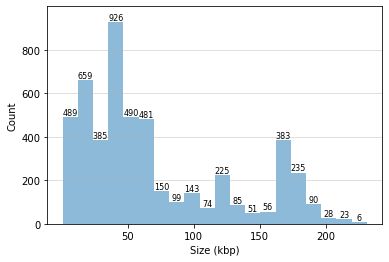

In [76]:
plt.figure(figsize=(6,4))
plt.grid(which='major', axis='y', alpha=0.5)
counts, edges, bars = plt.hist(sizeInsertion,bins=20, alpha=0.5)
plt.bar_label(bars, size=8)
plt.xlabel('Size (kbp)')
plt.ylabel('Count')
plt.xticks([50000,100000,150000,200000],[50,100,150,200])
plt.ylim(0,999)
plt.savefig('../../../thesisLatex/figures/04_results&Discussion/RGPs_sizeDistributionInsertions.png')
plt.show()

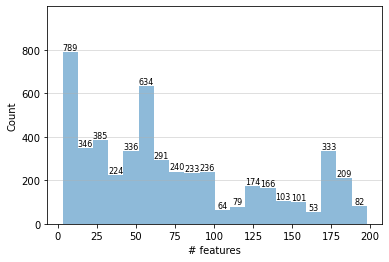

In [75]:
plt.figure(figsize=(6,4))
plt.grid(which='major', axis='y', alpha=0.5)
counts, edges, bars = plt.hist(possibleRGPs['InsertionNbFeatures'],bins=20, alpha=0.5)
plt.bar_label(bars, size=8)
plt.xlabel('# features')
plt.ylabel('Count')
plt.ylim(0,999)
plt.savefig('../../../thesisLatex/figures/04_results&Discussion/RGPs_sizeDistributionInsertions_features.png')
plt.show()

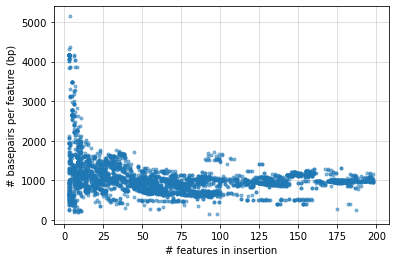

In [8]:
plt.figure(figsize=(6,4))
plt.grid(which='major', axis='both', alpha=0.5)
plt.plot(possibleRGPs['InsertionNbFeatures'], sizeInsertion/possibleRGPs['InsertionNbFeatures'], '.', alpha=0.5)
plt.xlabel('# features in insertion')
plt.ylabel('# basepairs per feature (bp)')
plt.savefig('../../../thesisLatex/figures/04_results&Discussion/RGPs_sizeDistributionInsertions_scatter.png')
plt.show()

Shorter insertions can have less genes per kbp.

## Nucleotide Statistics

In [5]:
from statistics import StatisticsError

GCTstats= []
GCPval = []
CAITstats = []
CAIPval = []
exceptionCounterGC = 0
exceptionCounterCAI = 0
for i in range(0,possibleRGPs.shape[0]):
    # t-test for GC
    try:
        insertion_avgGC = mean(x for x in possibleRGPs['InsertionListGC'].at[i] if x is not None)
        insertion_stdevGC = stdev(x for x in possibleRGPs['InsertionListGC'].at[i] if x is not None)
        strain_avgGC = possibleRGPs['StrainAvgGC'].at[i]
        strain_stdevGC = possibleRGPs['StrainStDevGC'].at[i]
        [statGC, pvalGC] = ttest_ind_from_stats(insertion_avgGC, insertion_stdevGC, possibleRGPs['InsertionNbFeatures'].at[i], strain_avgGC, strain_stdevGC, 5000)
        GCTstats.append(statGC)
        GCPval.append(pvalGC)
    except StatisticsError:
        GCTstats.append(np.nan)
        GCPval.append(np.nan)
        exceptionCounterGC += 1

    # t-test for CAI
    try:
        insertion_avgCAI = mean(x for x in possibleRGPs['InsertionListCAI'].at[i]if x is not None)
        insertion_stdevCAI = stdev(x for x in possibleRGPs['InsertionListCAI'].at[i]if x is not None)
        strain_avgCAI = possibleRGPs['StrainAvgCAI'].at[i]
        strain_stdevCAI = possibleRGPs['StrainStDevCAI'].at[i]
        [statCAI, pvalCAI] = ttest_ind_from_stats(insertion_avgCAI, insertion_stdevCAI, possibleRGPs['InsertionNbFeatures'].at[i], strain_avgCAI, strain_stdevCAI, 5000)
        CAITstats.append(statCAI)
        CAIPval.append(pvalCAI)
    except StatisticsError:
        CAITstats.append(np.nan)
        CAIPval.append(np.nan)
        exceptionCounterCAI += 1

In [23]:
print('Number of problems with calculating GC mean and variance:    ' + str(exceptionCounterGC))
print('Number of problems with calculating CAI mean and variance:    ' + str(exceptionCounterCAI))

Number of problems with calculating GC mean and variance:    2
Number of problems with calculating CAI mean and variance:    9


Histogram of the normalized average GC-values of the insertions that have a significantly different mean GC as compared to the strain.

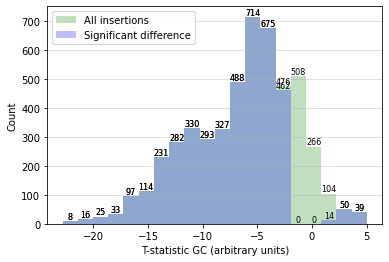

In [77]:
plt.figure(figsize=(6,4))
plt.grid(which='major', axis='y', alpha=0.5)
counts, edges, bars = plt.hist(GCTstats, bins=20, alpha=0.25, color='g', label='All insertions')
plt.bar_label(bars, size=8)
counts, edges, bars = plt.hist([GCTstats[i] for i in [idx for idx, element in enumerate(GCPval) if element < 0.05]], bins=20, alpha=0.25, color = 'b', label='Significant difference')
plt.bar_label(bars, size=8)
plt.xlabel('T-statistic GC (arbitrary units)')
plt.ylabel('Count')
plt.legend(loc='upper left')
plt.savefig('../../../thesisLatex/figures/04_results&Discussion/RPGs_GC_Tstat.png')
plt.show()

Histogram of the normalized average CAI-values of the insertions that have a significantly different mean CAI as compared to the strain.

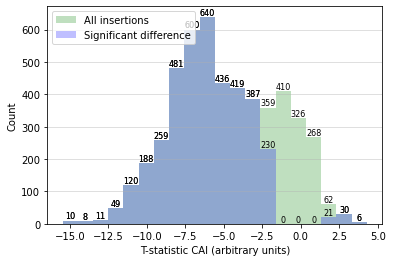

In [78]:
plt.figure(figsize=(6,4))
plt.grid(which='major', axis='y', alpha=0.5)
counts, edges, bars = plt.hist(CAITstats, bins=20, alpha=0.25, color='g', label='All insertions')
plt.bar_label(bars, size=8)
counts, edges, bars = plt.hist([CAITstats[i] for i in [idx for idx, element in enumerate(CAIPval) if element < 0.05]], bins=20, alpha=0.25, color = 'b', label='Significant difference')
plt.bar_label(bars, size=8)
plt.xlabel('T-statistic CAI (arbitrary units)')
plt.ylabel('Count')
plt.legend(loc='upper left')
plt.savefig('../../../thesisLatex/figures/04_results&Discussion/RPGs_CAI_Tstat.png')
plt.show()

In [6]:
bothSignificant = 0
onlyGCSignificant = 0
onlyCAISignificant = 0
noneSignificant = 0
problem = 0
for i in range(0,len(GCPval)):
    if np.isnan(GCPval[i]) or np.isnan(CAIPval[i]): problem += 1
    elif GCPval[i] < 0.05 and CAIPval[i] < 0.05: bothSignificant += 1
    elif GCPval[i] < 0.05 and CAIPval[i] >= 0.05: onlyGCSignificant += 1
    elif GCPval[i] >= 0.05 and CAIPval[i] < 0.05: onlyCAISignificant += 1
    else: noneSignificant += 1

print(bothSignificant, onlyGCSignificant, onlyCAISignificant, noneSignificant, problem)

3535 658 360 516 9


## Number of mobility genes

In [7]:
nbMobilityGenes = []
for i in range(0,possibleRGPs.shape[0]):
    nbMobilityGenes.append(len(possibleRGPs['InsertionListMobileNames'].at[i]))

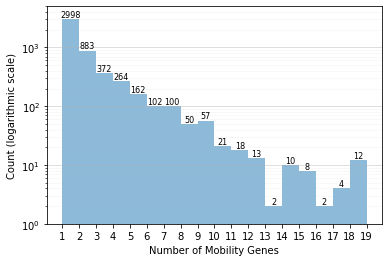

In [106]:
plt.figure(figsize=(6,4))
plt.grid(which='major', axis='y', alpha=0.5)
plt.grid(which='minor', axis='y', alpha=0.1)
counts, edges, bars = plt.hist(nbMobilityGenes, bins=np.arange(1,20), alpha=0.5, log=True)
plt.bar_label(bars, size=8)
plt.xticks(np.arange(1,20))
plt.ylim(1,5000)
plt.xlabel('Number of Mobility Genes')
plt.ylabel('Count (logarithmic scale)')
plt.savefig('../../../thesisLatex/figures/04_results&Discussion/RPGs_mobilityGenes.png')
plt.show()

## Number of tRNA genes

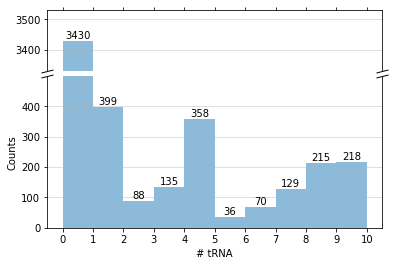

In [102]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(6,4), gridspec_kw={'height_ratios': [2,5]})
fig.subplots_adjust(hspace=0.05)

# upper plot
ax1.grid(which='major', axis='y', alpha=0.5)
counts, edges, bars = ax1.hist(possibleRGPs['InsertionNbTRNAs'], alpha=0.5)
ax1.bar_label(bars)

# lower plot
ax2.grid(which='major', axis='y', alpha=0.5)
counts, edges, bars = ax2.hist(possibleRGPs['InsertionNbTRNAs'], alpha=0.5)
ax2.bar_label(bars)
ax2.set_xticks(np.arange(0,10.1))
ax2.set_xlabel("# tRNA")
ax2.set_ylabel("Counts")

# limits
ax1.set_ylim(3330,3530)
ax2.set_ylim(0,499)

# hide the spines between ax and ax2
ax1.spines.bottom.set_visible(False)
ax2.spines.top.set_visible(False)
ax1.xaxis.tick_top()
ax1.tick_params(labeltop=False)  # don't put tick labels at the top
ax2.xaxis.tick_bottom()

# Now, let's turn towards the cut-out slanted lines.
# We create line objects in axes coordinates, in which (0,0), (0,1),
# (1,0), and (1,1) are the four corners of the axes.
# The slanted lines themselves are markers at those locations, such that the
# lines keep their angle and position, independent of the axes size or scale
# Finally, we need to disable clipping.

d = .25  # proportion of vertical to horizontal extent of the slanted line
kwargs = dict(marker=[(-1, -d), (1, d)], markersize=12,
              linestyle="none", color='k', mec='k', mew=1, clip_on=False)
ax1.plot([0, 1], [0, 0], transform=ax1.transAxes, **kwargs)
ax2.plot([0, 1], [1, 1], transform=ax2.transAxes, **kwargs)

plt.savefig('../../../thesisLatex/figures/04_results&Discussion/RPGs_tRNACounts.png')
plt.show()

## Number of insertions per strain

In [8]:
insertionsPerStrain = []
strainNames = possibleRGPs['StrainName'].unique()
for strainName in strainNames:
    nb = possibleRGPs[possibleRGPs['StrainName']==strainName].shape[0]
    insertionsPerStrain.append(nb)

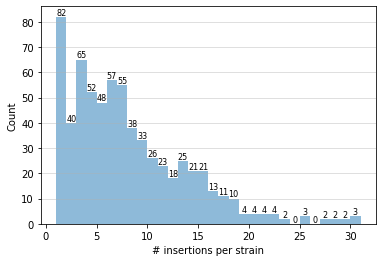

In [16]:
plt.figure(figsize=(6,4))
plt.grid(which='major', axis='y', alpha=0.5)
counts, edges, bars = plt.hist(insertionsPerStrain, bins = np.arange(1,32,1), alpha = 0.5)
plt.bar_label(bars, size=8)
plt.xlabel('# insertions per strain')
plt.ylabel('Count')
# plt.ylim(0,319)
plt.savefig('../../../thesisLatex/figures/04_results&Discussion/RPGs_insertionsPerStrain.png')
plt.show()

The total number of strains with insertions:

In [13]:
len(insertionsPerStrain)

668

The strains with most insertions:

In [14]:
max(insertionsPerStrain)

30

In [19]:
indices = [index for index, item in enumerate(insertionsPerStrain) if item == 30]
for i in indices:
    print(strainNames[i])

GCF_002085605_1
GCF_013393685_1
GCA_013393685_1


## Anchors occuring in both directions

let's first check if anchors from the first column occur in the second column and if in that case, the second anchor is also switched. (than an inversion has happened)

To show that the code works, imagine that the following anchor pairs exist: A & B. `AnchorsMapping['A']` would then contain 'B' and `AnchorsMapping['B']` would contain 'A'. A tuple ('A', 'B') would be created in the nested for-loop. If test is executed, the only tuple is ('A', 'B').

In [78]:
# Make dicionary keys anchor1, values set of anchor2s
anchorsMapping = {}

for anchor1id in possibleRGPs['Anchor1ID'].unique():
    anchor2ids=possibleRGPs[possibleRGPs['Anchor2ID'] == anchor1id]['Anchor2ID'].to_list()
    anchorsMapping[anchor1id] = set(anchor2ids)

# Next two lines to test the code
# anchorsMapping['A'] = {'B'}
# anchorsMapping['B'] = {'A'}

# For each anchor 2, check if that cluster is an anchor 1 with the original anchor 1 as anchor 2
insertionSitesInBothDirections = set()
for anchor1id in anchorsMapping.keys():
    for anchor2id in anchorsMapping[anchor1id]:
        if anchor1id == anchor2id: continue
        if anchor1id in anchorsMapping[anchor2id]:
            if anchor1id < anchor2id:
                tuple = (anchor1id, anchor2id)
            else:
                tuple = (anchor2id, anchor1id)
            insertionSitesInBothDirections.add(tuple)

In [79]:
insertionSitesInBothDirections

set()

## Anchors with insertions in multiple strains
dictionary with keys tuples of anchors (anchor 1 in position 1, anchor 2 in position 2) and values set of strains they occur in. Size of the sets can be used to visualize the distribution of number of strains an insertion happened in.

In [4]:
anchorTupleToStrain = {}
for i in range(0,possibleRGPs.shape[0]):
    tuple = (possibleRGPs['Anchor1ID'].at[i], possibleRGPs['Anchor2ID'].at[i])
    strain = possibleRGPs['StrainName'].at[i]
    if tuple not in anchorTupleToStrain.keys():
        anchorTupleToStrain[tuple] = {strain}
    else:
        anchorTupleToStrain[tuple].add(strain)

keys = list(anchorTupleToStrain.keys())
values = list(anchorTupleToStrain.values())

nbStrainsWithInsertion = []
for tuple in keys:
    nb = len(anchorTupleToStrain[tuple])
    nbStrainsWithInsertion.append(nb)

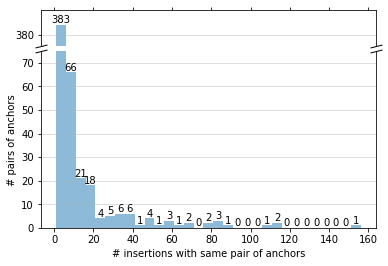

In [29]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(6,4), gridspec_kw={'height_ratios': [1,5]})
fig.subplots_adjust(hspace=0.05)

# upper plot
ax1.grid(which='major', axis='y', alpha=0.5)
counts, edges, bars = ax1.hist(nbStrainsWithInsertion, np.arange(1,161,5), alpha=0.5)
ax1.bar_label(bars)
ax1.set_yticks([380])

# lower plot
ax2.grid(which='major', axis='y', alpha=0.5)
counts, edges, bars = ax2.hist(nbStrainsWithInsertion, np.arange(1,161,5), alpha=0.5)
ax2.bar_label(bars)
ax2.set_xlabel('# insertions with same pair of anchors')
ax2.set_ylabel('# pairs of anchors')

# limits
ax1.set_ylim(377,387)
ax2.set_ylim(0,75)

# hide the spines between ax and ax2
ax1.spines.bottom.set_visible(False)
ax2.spines.top.set_visible(False)
ax1.xaxis.tick_top()
ax1.tick_params(labeltop=False)  # don't put tick labels at the top
ax2.xaxis.tick_bottom()

# Now, let's turn towards the cut-out slanted lines.
# We create line objects in axes coordinates, in which (0,0), (0,1),
# (1,0), and (1,1) are the four corners of the axes.
# The slanted lines themselves are markers at those locations, such that the
# lines keep their angle and position, independent of the axes size or scale
# Finally, we need to disable clipping.

d = .25  # proportion of vertical to horizontal extent of the slanted line
kwargs = dict(marker=[(-1, -d), (1, d)], markersize=12,
              linestyle="none", color='k', mec='k', mew=1, clip_on=False)
ax1.plot([0, 1], [0, 0], transform=ax1.transAxes, **kwargs)
ax2.plot([0, 1], [1, 1], transform=ax2.transAxes, **kwargs)

plt.savefig('../../../thesisLatex/figures/04_results&Discussion/RPGs_insertionsPerAnchor.png')
plt.show()

## Relatedness of strains with insertions in the same anchors

Pirate generated a tree based on binary presence/absence. Import this using biopython and calculate distances between the strains. If strains have large distance, but insertion in same spot, this might be indicative of GI. Then, we could look at the relatedness of the insertion itself.

In [5]:
tree = Phylo.read("../02_pirateOutput/binary_presence_absence.nwk", "newick")

In [6]:
i = 0
indexAnchors = []
pairwiseDistances = []
indexToAnchors = {}
for key in keys:
    strains = list(anchorTupleToStrain[key])
    for n in range(0,len(strains)-1):
        for m in range(n+1, len(strains)):
            indexAnchors.append(i)
            pairwiseDistances.append(tree.distance(strains[n],strains[m]))
    indexToAnchors[i] = key
    i+=1

KeyboardInterrupt: 

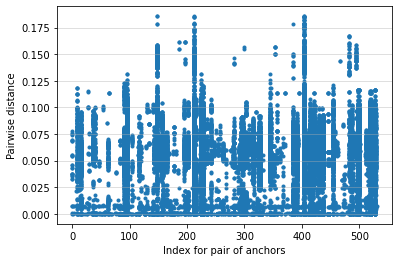

In [78]:
plt.figure(figsize=(6,4))

plt.grid(which='major', axis='y', alpha=0.5)

plt.scatter(indexAnchors, pairwiseDistances, marker='.')

plt.xlabel('Index for pair of anchors')
plt.ylabel('Pairwise distance')

plt.savefig('../../../thesisLatex/figures/04_results&Discussion/RPGs_DistributionPhylogeneticDistances.png')
plt.show()

Violin plots of min, avg, max distances:

In [243]:
minDistances = []
avgDistances = []
maxDistances = []
indexMinAvgMax = []
for i in range(0,max(indexAnchors)+1):
    idxs = [idx for idx, value in enumerate(indexAnchors) if value == i]
    if idxs == []: continue # some idxs don't occur, as the anchors only have one insertion and no distance can be calculated
    distances = [value for idx, value in enumerate(pairwiseDistances) if idx in idxs]
    minDistances.append(min(distances))
    avgDistances.append(mean(distances))
    maxDistances.append(max(distances))
    indexMinAvgMax.append(i)

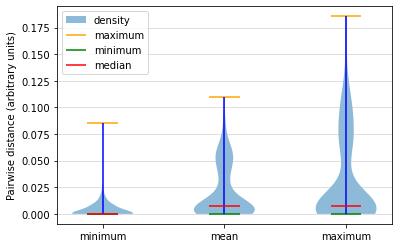

In [244]:
plt.figure(figsize=(6,4))

# add a grid to the figure
plt.grid(which='major', axis='y', alpha=0.5)

# the violin plot
dict = plt.violinplot([minDistances, avgDistances, maxDistances], showmedians=True)

# change some visuals of the plot
dict['cmedians'].set_color('red')
for body in dict['bodies']: body.set_alpha(0.5)
dict['cbars'].set_color('blue')
dict['cmins'].set_color('green')
dict['cmaxes'].set_color('orange')

# change axes properties
plt.xticks([1,2,3], ['minimum', 'mean', 'maximum'])
plt.ylabel('Pairwise distance (arbitrary units)')

# add legend
dict['cmedians'].set_label('median')
dict['bodies'][0].set_label('density')
dict['cmins'].set_label('minimum')
dict['cmaxes'].set_label('maximum')
plt.legend(loc='upper left')

plt.savefig('../../../thesisLatex/figures/04_results&Discussion/RPGs_MinMeanMaxPhylogeneticDistances.png')
plt.show()

Tree can be imported in iTOL. Strains can get a marker. Visualize for the anchors that have insertions in the most distant set of strains. (execute the cells and copy the dataframes in the right iTOL dataset template)

In [35]:
# get strain index of max value
maxIndex = pairwiseDistances.index(max(pairwiseDistances))
indexAnchor = indexAnchors[maxIndex]

# find min, mean, max distance of that same anchor pair
idxs = [idx for idx, value in enumerate(indexAnchors) if value == indexAnchor]
distances = [value for idx, value in enumerate(pairwiseDistances) if idx in idxs]
minDistance = min(distances)
meanDistance = mean(distances)
maxDistance = max(distances)

print('number of distances:\t', len(anchorTupleToStrain[indexToAnchors[indexAnchor]]), 
'\nmin distance:\t', minDistance, 
'\nmean distance:\t', meanDistance, 
'\nmax distance:\t', maxDistance)

number of distances:	 57 
min distance:	 0.0 
mean distance:	 0.07413316272305764 
max distance:	 0.185581453


The anchors with max distance don't have max mean or max min.

iTOL has a feature to connect strains. Visualize for the anchors that have insertions in the most distant set of strains. This results in a nice visualization.

In [86]:
maxIndex = pairwiseDistances.index(max(pairwiseDistances))
dict = {'strain1':[],'strain2':[],'width':[],'color':[],'style':[],'label':[]}
strains = list(anchorTupleToStrain[list(anchorTupleToStrain.keys())[indexAnchors[maxIndex]]])
for n in range(0,len(strains)-1):
    for m in range(n+1, len(strains)):
        dict['strain1'].append(strains[n])
        dict['strain2'].append(strains[m])
        dict['width'].append(1)
        dict['color'].append('#ff0000')
        dict['style'].append('normal')
        dict['label'].append(key)
pd.DataFrame.from_dict(dict).to_clipboard(index=False, header=False, sep=',')

![](../05_GenomicIslands/TreeFigures/connectionsLongestDistance.svg)

Similar plot for anchors with max mean:

In [36]:
# get strain index of max mean distance
idx = [idx for idx, value in enumerate(avgDistances) if value == max(avgDistances)][0]
indexAnchor = indexMinAvgMax[idx]

# find min, mean, max distance of that same anchor pair
idxs = [idx for idx, value in enumerate(indexAnchors) if value == indexAnchor]
distances = [value for idx, value in enumerate(pairwiseDistances) if idx in idxs]
minDistance = min(distances)
meanDistance = mean(distances)
maxDistance = max(distances)

print('number of distances:\t', len(anchorTupleToStrain[indexToAnchors[indexAnchor]]), 
'\nmin distance:\t', minDistance, 
'\nmean distance:\t', meanDistance, 
'\nmax distance:\t', maxDistance)

number of distances:	 4 
min distance:	 0.000325063 
mean distance:	 0.10935033166666666 
max distance:	 0.16128083599999998


In [99]:
dict = {'strain1':[],'strain2':[],'width':[],'color':[],'style':[],'label':[]}
strains = list(anchorTupleToStrain[list(anchorTupleToStrain.keys())[indexAnchor]])
for n in range(0,len(strains)-1):
    for m in range(n+1, len(strains)):
        dict['strain1'].append(strains[n])
        dict['strain2'].append(strains[m])
        dict['width'].append(1)
        dict['color'].append('#ff0000')
        dict['style'].append('normal')
        dict['label'].append(key)
pd.DataFrame.from_dict(dict).to_clipboard(index=False, header=False, sep=',')

similar plot for anchors with max min distance

In [38]:
# get strain index of max value
idx = [idx for idx, value in enumerate(avgDistances) if value == max(minDistances)]
indexAnchor = indexMinAvgMax[idx[1]]

# find min, mean, max distance of that same anchor pair
idxs = [idx for idx, value in enumerate(indexAnchors) if value == indexAnchor]
distances = [value for idx, value in enumerate(pairwiseDistances) if idx in idxs]
minDistance = min(distances)
meanDistance = mean(distances)
maxDistance = max(distances)

print('number of strains:\t', len(anchorTupleToStrain[indexToAnchors[indexAnchor]]), 
'\nmin distance:\t', minDistance, 
'\nmean distance:\t', meanDistance, 
'\nmax distance:\t', maxDistance)

number of strains:	 2 
min distance:	 0.085147474 
mean distance:	 0.085147474 
max distance:	 0.085147474


In [102]:
dict = {'strain1':[],'strain2':[],'width':[],'color':[],'style':[],'label':[]}
strains = list(anchorTupleToStrain[list(anchorTupleToStrain.keys())[indexAnchor]])
for n in range(0,len(strains)-1):
    for m in range(n+1, len(strains)):
        dict['strain1'].append(strains[n])
        dict['strain2'].append(strains[m])
        dict['width'].append(1)
        dict['color'].append('#ff0000')
        dict['style'].append('normal')
        dict['label'].append(key)
pd.DataFrame.from_dict(dict).to_clipboard(index=False, header=False, sep=',')

Generate a similar plot for the anchors with insertions in the most strains.

In [42]:
nbStrains = []
for value in values:
    nbStrains.append(len(value))

maxIndex = nbStrains.index(max(nbStrains))

dict = {'strain1':[],'strain2':[],'width':[],'color':[],'style':[],'label':[]}
strains = list(values[maxIndex])
for n in range(0,len(strains)-1):
    for m in range(n+1, len(strains)):
        dict['strain1'].append(strains[n])
        dict['strain2'].append(strains[m])
        dict['width'].append(1)
        dict['color'].append('#ff0000')
        dict['style'].append('normal')
        dict['label'].append(keys[maxIndex])
pd.DataFrame.from_dict(dict).to_clipboard(index=False, header=False, sep=',')

In [43]:
strains = list(anchorTupleToStrain[keys[maxIndex]])
distances = []
for n in range(0,len(strains)-1):
    for m in range(n+1, len(strains)):
        indexAnchors.append(i)
        distances.append(tree.distance(strains[n],strains[m]))

print('number of strains:\t', len(strains), 
'\nmin distance:\t', min(distances), 
'\nmean distance:\t', mean(distances), 
'\nmax distance:\t', max(distances))

number of strains:	 155 
min distance:	 0.0 
mean distance:	 0.059581962341013824 
max distance:	 0.185581453


![hello](../05_GenomicIslands/TreeFigures/connectionsMostStrains.svg)

## Comparing relatedness of strains and their insertions

### Nb of common clusters (Test, better method is presence/absence in next section)

I'll determine the clusters that insertions have in common in a pair-wise fashion. This can be used as some sort of proxy for relatedness of the insertion. This can then be compared to strain similarity (perhaps the total number of clusters that two strains have in common). If the insertion has a higher fraction of clusters in common, it might be seen as evidence that the insertion is some sort of GI.

In [7]:
# create square matrix with ones as default value
nRow = possibleRGPs.shape[0]
nCol = possibleRGPs.shape[0]
similarityMatrix = np.ones((nRow,nCol))
# Iterate over each element in the matrix and calculate similarity measure
for m in range(0,nRow-1):
    clusterIDs_insertion1 = set(possibleRGPs['InsertionListClusterID'].at[m])
    length_insertion1 = len(clusterIDs_insertion1)
    for n in range(m+1,nCol):
        clusterIDs_insertion2 = set(possibleRGPs['InsertionListClusterID'].at[n])
        length_insertion2 = len(clusterIDs_insertion2)
        nbCommonClusters = len(clusterIDs_insertion1.intersection(clusterIDs_insertion2))
        # The matrix is symmetric
        # Simmilarity measure: normalized by dividing by both insertion lengths.
        # This measure is 1 if all clusters are shared, but cannot become one if one insertion
        # is longer than the other. Measure is 0 if no clusters in common. If one insertion 
        # much longer than other one, simmilarity measure will be low
        similarityMatrix[m][n] = (2*nbCommonClusters)/(length_insertion1+length_insertion2)
        similarityMatrix[n][m] = (2*nbCommonClusters)/(length_insertion1+length_insertion2)

KeyboardInterrupt: 

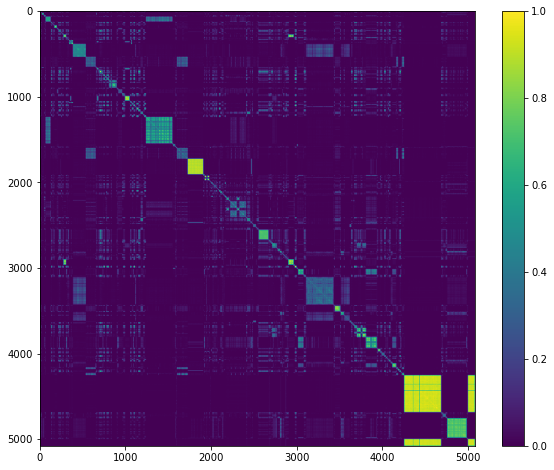

In [119]:
plt.figure(figsize=(10,8))
plt.imshow(similarityMatrix)
plt.colorbar()
plt.show()

This plot shows that there are regions with highly similar insertions. Now, we have to check if those similar insertions happend in strains with different evolutionary backgrounds. If this is the case, they are likely GIs.

Per set of strains with a similarity measure above a certain threshold, determine the evolutionary distance between those strains. Or, make a list of genomes for the largest blocks of similar insertions and visualize in iTOL.

### Using presence/absence matrix of genes in possible insertions

1) Generate a matrix with row for each putative insertion, column for each cluster occuring in at least one putative insertion.
2) Calculate distance between all observations. `scipy.spatial.distnce.pdist` is a possible method for this.
3) Perform hierarchical clustering. `scipy.cluster.hyierarchy.linkage` is a possible method for this.
4) Use some metric to determine the ideal number of clusters to be used. Obtain the insertions and to which cluster they belong.
5) Visualize in iTOL. If clusters are distributed over the phylogenetic tree, we may have found genomic islands.
6) Do insertion clusters correlate with insertion sites?

#### Step 1
Make a set with all clusterIDs

In [9]:
clusterIDs = set()
for i in range(0,possibleRGPs.shape[0]):
    clusterIDsInStrain = set(possibleRGPs['InsertionListClusterID'].at[i])
    clusterIDs = clusterIDs.union(clusterIDsInStrain)

Make a dataframe with counts for each cluster.

In [12]:
countsDict = {}
for clusterID in clusterIDs:
    countsDict[clusterID] = []
for i in range(0,possibleRGPs.shape[0]):
    clusterIDsInStrain = possibleRGPs['InsertionListClusterID'].at[i]
    for clusterID in clusterIDs:
        count = clusterIDsInStrain.count(clusterID)
        countsDict[clusterID].append(count)

In [13]:
countsDF = pd.DataFrame.from_dict(countsDict)
countsDF

,g006889_000002,g009840_000006,g013022_000006,g000482_2_000002,g005102_000003,g000135_2_000223,g013674_000006,g000274_8_000001,g002134_2_000003,g008412_000004,...,g003496_000005,g007760_000003,g002620_000004,g000239_000002,g015798_000006,g006051_000005,g007406_1_000006,g000119_42_000425,g001383_1_000007,g002893_000003
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5073,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
5074,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
5075,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
5076,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### Step 2

Calculate distance between all the putative insertions.

In [14]:
pairwiseDistance = pdist(countsDF, 'jaccard') # proportion of elements that disagree -> want to minimize this

In [15]:
pairwiseDistance

array([0.94444444, 0.94444444, 0.94545455, ..., 1.        , 1.        ,
       0.30769231])

In [16]:
paiwiseDistSquare = squareform(pairwiseDistance)

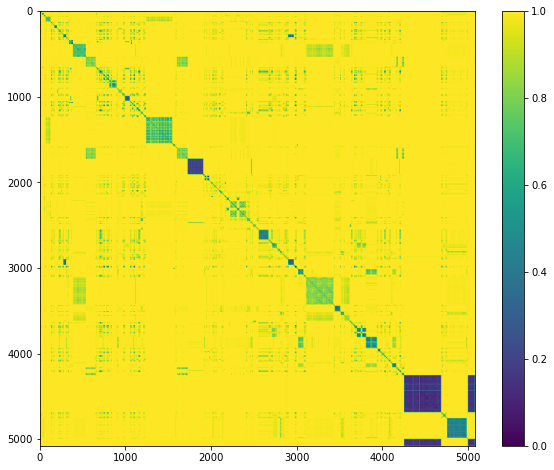

In [17]:
plt.figure(figsize=(10,8))
plt.imshow(paiwiseDistSquare)
plt.colorbar()
plt.clim(0,1)
plt.show()

#### Step 3
Clustering

In [18]:
linkageMatrix = linkage(pairwiseDistance, 'complete')

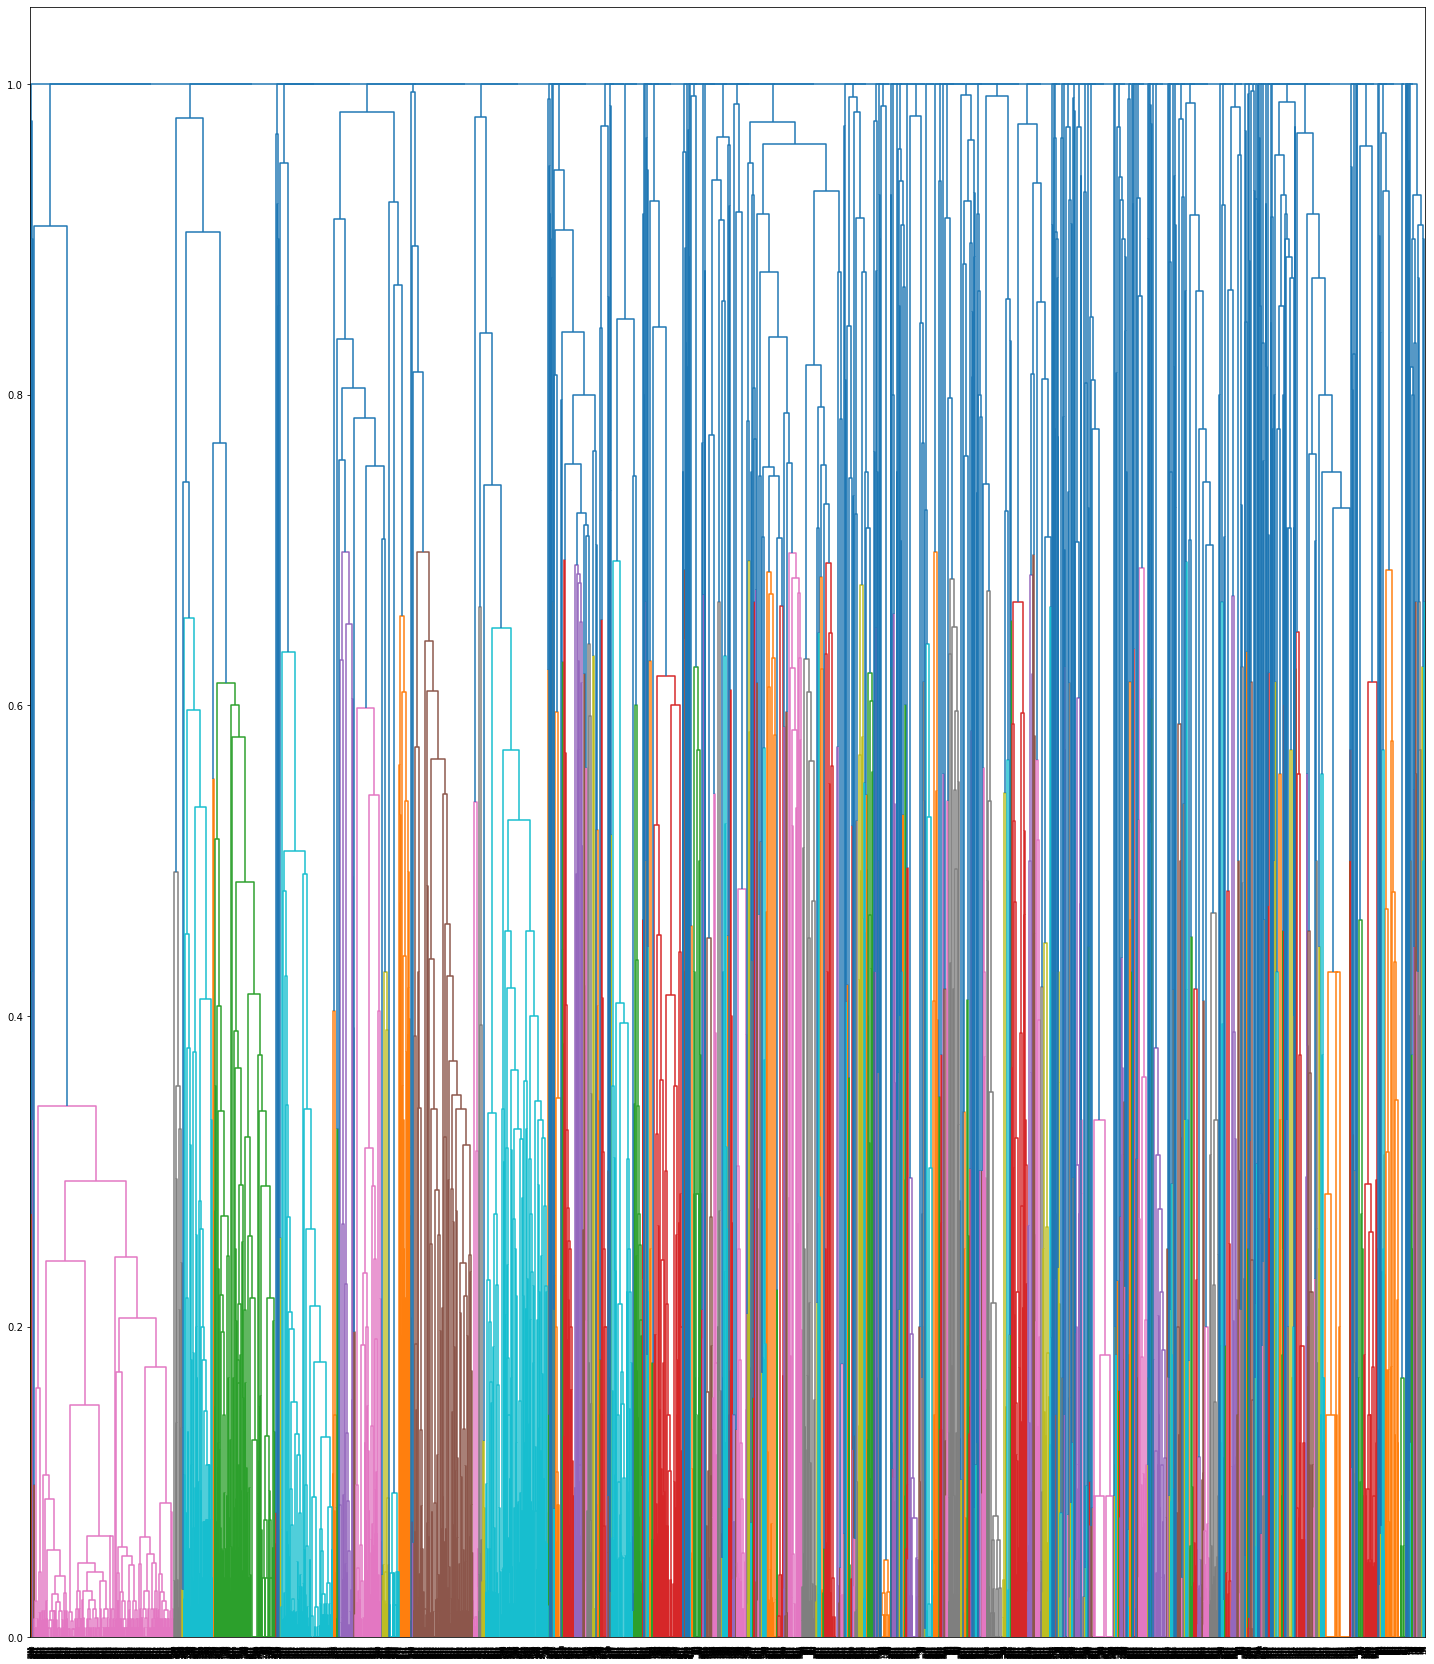

In [19]:
fig = plt.figure(figsize=(25,30))
dn = dendrogram(linkageMatrix)
plt.show()

#### Step 4
Flattening the dendrogram in such a way that the resulting clusters hold relevant groupings of the insertions.

In [20]:
clusterLabels = fcluster(linkageMatrix, 0.3, criterion='distance')

In [21]:
clusterLabels.max()

876

In [22]:
clusterLabel, nbElements = np.unique(clusterLabels, return_counts=True)
clustersAndSize = pd.DataFrame.from_dict({'clusterLabel': clusterLabel, 'nbElements': nbElements})
clustersAndSize.sort_values(by='nbElements',ascending=False).iloc[0:10,]

,clusterLabel,nbElements
9,10,479
55,56,100
611,612,71
52,53,60
41,42,57
22,23,47
818,819,44
521,522,44
801,802,42
38,39,40


In [23]:
clustersAndSize['nbElements'].std()

17.803621816127542

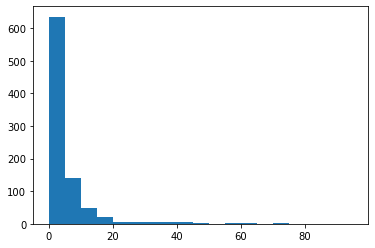

In [24]:
plt.figure()
plt.hist(clustersAndSize.sort_values(by='nbElements',ascending=False)['nbElements'], bins=np.arange(0,100,5))
plt.show()

In [25]:
# retrieving the insertions from this cluster
indexesOfInsertionsInCLuster1 = np.where(clusterLabels==612)[0]
indexesOfInsertionsInCLuster2 = np.where(clusterLabels==42)[0]
indexesOfInsertionsInCLuster3 = np.where(clusterLabels==522)[0]

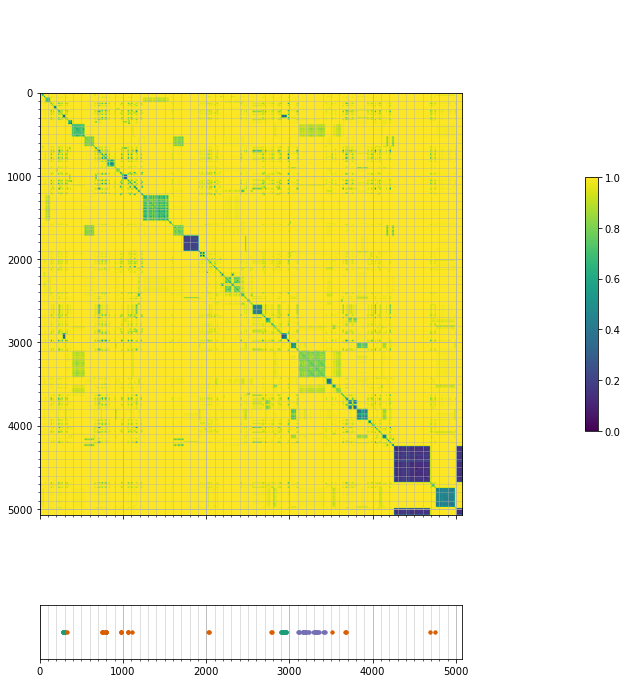

In [26]:
# plot this
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, sharex=True, figsize=(10,12), gridspec_kw={'height_ratios': [11,1], 'width_ratios': [5,1]})
fig.subplots_adjust(hspace=0.01)

im = ax1.imshow(paiwiseDistSquare)
fig.colorbar(im, ax=ax2)
ax3.plot(indexesOfInsertionsInCLuster1, np.ones(indexesOfInsertionsInCLuster1.shape), '#1b9e77', marker = '.', linestyle = '')
ax3.plot(indexesOfInsertionsInCLuster2, np.ones(indexesOfInsertionsInCLuster2.shape), '#d95f02', marker = '.', linestyle = '')
ax3.plot(indexesOfInsertionsInCLuster3, np.ones(indexesOfInsertionsInCLuster3.shape), '#7570b3', marker = '.', linestyle = '')

ax1.yaxis.set_minor_locator(MultipleLocator(100))

ax3.set_yticks([])
ax3.xaxis.set_minor_locator(MultipleLocator(100))

ax1.grid(which='major', axis='both', alpha=1)
ax1.grid(which='minor', axis='both', alpha=0.5)
ax3.grid(which='major', axis='x', alpha=1)
ax3.grid(which='minor', axis='x', alpha=0.5)

ax2.axis('off')
ax4.axis('off')

plt.savefig('../../../thesisLatex/figures/04_results&Discussion/RPGs_insertions_distanceMatrix.png')
plt.show()

In [27]:
# retrieve the strains and plot them.
dict = {'strain':[],'value':[]}
for strain in possibleRGPs['StrainName'].iloc[indexesOfInsertionsInCLuster3]:
    dict['strain'].append(strain)
    dict['value'].append(1)
pd.DataFrame.from_dict(dict).to_clipboard(index=False, header=False, sep='\t')

In [28]:
sims = []
dict = {'strain1':[],'strain2':[],'width':[],'color':[],'style':[],'label':[]}
strains = possibleRGPs['StrainName'].iloc[indexesOfInsertionsInCLuster2].tolist()
for n in range(0,len(strains)-1):
    for m in range(n+1, len(strains)):
        dict['strain1'].append(strains[n])
        dict['strain2'].append(strains[m])
        dict['width'].append(1)
        # similarity determines color:
        sims.append(paiwiseDistSquare[indexesOfInsertionsInCLuster1[n],indexesOfInsertionsInCLuster1[m]])
        dict['style'].append('normal')
        dict['label'].append(keys[maxIndex])

label_colors, colordict = colourmap.fromlist(sims)
dict['color'] = colourmap.rgb2hex(label_colors)
pd.DataFrame.from_dict(dict).to_clipboard(index=False, header=False, sep=',')

NameError: name 'keys' is not defined

coloring is done as described here: https://erdogant.github.io/colourmap/pages/html/Examples.html#create-color-based-on-input-labels

#### Getting some info on the insertion sites

##### Size

In [29]:
indexesOfInsertionsPerCluster = {1: np.where(clusterLabels==612)[0], 
                                2: np.where(clusterLabels==42)[0],
                                3: np.where(clusterLabels==522)[0]}

keys = list(indexesOfInsertionsPerCluster.keys())

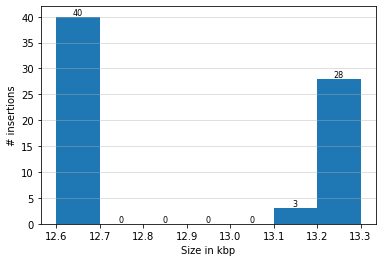

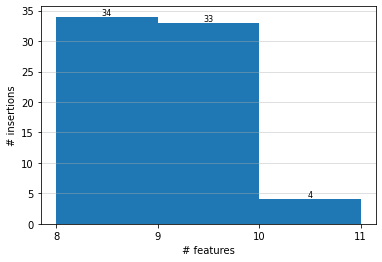

In [30]:
# cluster 1

plt.figure(figsize=(6,4))
plt.grid(which='major', axis='y', alpha=0.5)
counts, edges, bars = plt.hist(possibleRGPs['InsertionEnd'].iloc[indexesOfInsertionsPerCluster[1]]-possibleRGPs['InsertionStart'].iloc[indexesOfInsertionsPerCluster[1]], bins=np.arange(12600,13400,100))
plt.bar_label(bars, size=8)
plt.xticks(np.arange(12600,13400,100), [12.6,12.7,12.8,12.9,13.0,13.1,13.2,13.3])
plt.xlabel('Size in kbp')
plt.ylabel('# insertions')
plt.savefig('../../../thesisLatex/figures/04_results&Discussion/RPGs_insertionSize_cluster1.png')
plt.show()

plt.figure(figsize=(6,4))
plt.grid(which='major', axis='y', alpha=0.5)
counts, edges, bars = plt.hist(possibleRGPs['InsertionNbFeatures'].iloc[indexesOfInsertionsPerCluster[1]], bins=np.arange(8,12))
plt.bar_label(bars, size=8)
plt.xticks(np.arange(8,12))
plt.xlabel('# features')
plt.ylabel('# insertions')
plt.savefig('../../../thesisLatex/figures/04_results&Discussion/RPGs_insertionNbFeatures_cluster1.png')
plt.show()

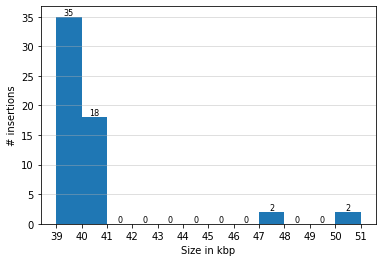

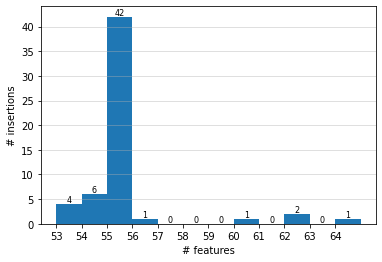

In [31]:
# cluster 2

plt.figure(figsize=(6,4))
plt.grid(which='major', axis='y', alpha=0.5)
counts, edges, bars = plt.hist(possibleRGPs['InsertionEnd'].iloc[indexesOfInsertionsPerCluster[2]]-possibleRGPs['InsertionStart'].iloc[indexesOfInsertionsPerCluster[2]], bins=np.arange(39000,52000,1000))
plt.bar_label(bars, size=8)
plt.xticks(np.arange(39000,52000,1000), np.arange(39,52,1))
plt.xlabel('Size in kbp')
plt.ylabel('# insertions')
plt.savefig('../../../thesisLatex/figures/04_results&Discussion/RPGs_insertionSize_cluster2.png')
plt.show()

plt.figure(figsize=(6,4))
plt.grid(which='major', axis='y', alpha=0.5)
counts, edges, bars = plt.hist(possibleRGPs['InsertionNbFeatures'].iloc[indexesOfInsertionsPerCluster[2]], bins=np.arange(53,66))
plt.bar_label(bars, size=8)
plt.xticks(np.arange(53,65))
plt.xlabel('# features')
plt.ylabel('# insertions')
plt.savefig('../../../thesisLatex/figures/04_results&Discussion/RPGs_insertionNbFeatures_cluster2.png')
plt.show()

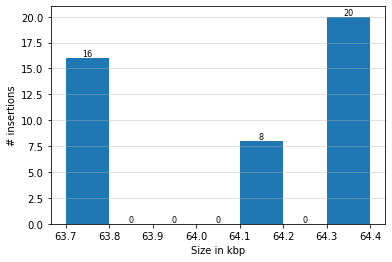

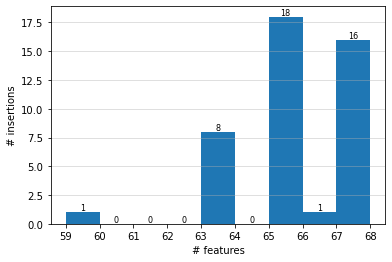

In [32]:
# cluster 3

from numpy import arange


plt.figure(figsize=(6,4))
plt.grid(which='major', axis='y', alpha=0.5)
counts, edges, bars = plt.hist(possibleRGPs['InsertionEnd'].iloc[indexesOfInsertionsPerCluster[3]]-possibleRGPs['InsertionStart'].iloc[indexesOfInsertionsPerCluster[3]], bins=np.arange(63700,64500,100))
plt.bar_label(bars, size=8)
plt.xticks(np.arange(63700,64500,100), [63.7,63.8,63.9,64.0,64.1,64.2,64.3,64.4])
plt.xlabel('Size in kbp')
plt.ylabel('# insertions')
plt.savefig('../../../thesisLatex/figures/04_results&Discussion/RPGs_insertionSize_cluster3.png')
plt.show()

plt.figure(figsize=(6,4))
plt.grid(which='major', axis='y', alpha=0.5)
counts, edges, bars = plt.hist(possibleRGPs['InsertionNbFeatures'].iloc[indexesOfInsertionsPerCluster[3]], bins=np.arange(59,69))
plt.bar_label(bars, size=8)
plt.xticks(np.arange(59,69))
plt.xlabel('# features')
plt.ylabel('# insertions')
plt.savefig('../../../thesisLatex/figures/04_results&Discussion/RPGs_insertionNbFeatures_cluster3.png')
plt.show()

##### nb of genes insertions in clusters have in common.

1. select the insertions from counts matrix that are present in the cluster.
2. remove the columns that are zero everywhere (features not present in any of the insertions from the cluster)
3. Calculate for each feature in how many insertions they are present. Visualize in histogram. 
4. If there is a core set of features in the insertions, what is their function? Does this give an indication of the function of the insertion? 
5. Is the insertion known? Check for example IslandViwer for one of the strains that contain the insertion.

In [33]:
# step 1
featureCountsCluster1 = countsDF.iloc[indexesOfInsertionsPerCluster[1]]
featureCountsCluster2 = countsDF.iloc[indexesOfInsertionsPerCluster[2]]
featureCountsCluster3 = countsDF.iloc[indexesOfInsertionsPerCluster[3]]

In [34]:
# step 2
featureCountsCluster1 = featureCountsCluster1.loc[:,featureCountsCluster1.sum(axis=0) != 0]
featureCountsCluster2 = featureCountsCluster2.loc[:,featureCountsCluster2.sum(axis=0) != 0]
featureCountsCluster3 = featureCountsCluster3.loc[:,featureCountsCluster3.sum(axis=0) != 0]

In [35]:
featureToNbInsertionsCount1 = {}
for colName, colData in featureCountsCluster1.iteritems(): 
    nbInsertionsCount = colData.loc[colData != 0].size
    featureToNbInsertionsCount1[colName] = nbInsertionsCount

featureToNbInsertionsCount2 = {}
for colName, colData in featureCountsCluster2.iteritems(): 
    nbInsertionsCount = colData.loc[colData != 0].size
    featureToNbInsertionsCount2[colName] = nbInsertionsCount

featureToNbInsertionsCount3 = {}
for colName, colData in featureCountsCluster3.iteritems(): 
    nbInsertionsCount = colData.loc[colData != 0].size
    featureToNbInsertionsCount3[colName] = nbInsertionsCount

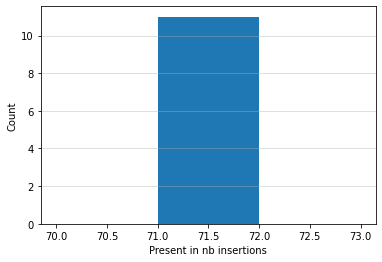

In [36]:
# cluster 1
plt.figure(figsize=(6,4))
plt.grid(which='major', axis='y', alpha=0.5)
counts, edges, bars = plt.hist(list(featureToNbInsertionsCount1.values()), bins=np.arange(70,74))
# plt.bar_label(bars, size=8)
plt.xlabel('Present in nb insertions')
plt.ylabel('Count')
plt.savefig('../../../thesisLatex/figures/04_results&Discussion/RPGs_inHowManyInsertions_cluster1.png')
plt.show()

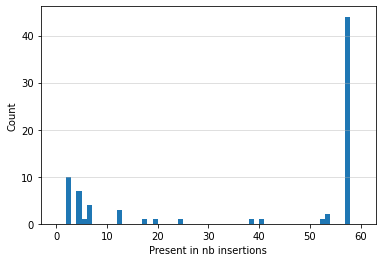

In [37]:
# cluster 2

plt.figure(figsize=(6,4))
plt.grid(which='major', axis='y', alpha=0.5)
counts, edges, bars = plt.hist(list(featureToNbInsertionsCount2.values()), bins=np.arange(0,61))
# plt.bar_label(bars, size=8)
plt.xlabel('Present in nb insertions')
plt.ylabel('Count')
plt.savefig('../../../thesisLatex/figures/04_results&Discussion/RPGs_inHowManyInsertions_cluster2.png')
plt.show()

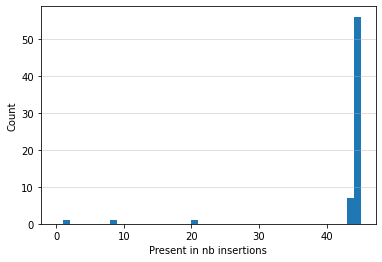

In [38]:
# cluster 3

plt.figure(figsize=(6,4))
plt.grid(which='major', axis='y', alpha=0.5)
counts, edges, bars = plt.hist(list(featureToNbInsertionsCount3.values()), bins=np.arange(0,46))
# plt.bar_label(bars, size=8)
plt.xlabel('Present in nb insertions')
plt.ylabel('Count')
plt.savefig('../../../thesisLatex/figures/04_results&Discussion/RPGs_inHowManyInsertions_cluster3.png')
plt.show()

In [39]:
# step 4: determine the core features
core_features1 = []
for feature in list(featureToNbInsertionsCount1.keys()):
    count = featureToNbInsertionsCount1[feature]
    if count > 0.95*featureCountsCluster1.shape[0]: core_features1.append(feature)

core_features2 = []
for feature in list(featureToNbInsertionsCount2.keys()):
    count = featureToNbInsertionsCount2[feature]
    if count > 0.95*featureCountsCluster2.shape[0]: core_features2.append(feature)

core_features3 = []
for feature in list(featureToNbInsertionsCount3.keys()):
    count = featureToNbInsertionsCount3[feature]
    if count > 0.95*featureCountsCluster3.shape[0]: core_features3.append(feature)

In [40]:
def getDescriptionCluster_work(tx: neo4j.Session, cluster_id: str):
    result = tx.run("""
        match (c:CLUSTER {cluster_id: $cluster_id})
        return c.description as description, c.number_genomes as number_genomes
    """, cluster_id=cluster_id)
    return result.values('description', 'number_genomes')

def getDescriptionCluster(driver: neo4j.Driver, core_features):
    dict = {'cluster_id': [], 'description': [], 'number_genomes': []}
    for core_feature in core_features:
        with driver.session() as session:
            result = session.read_transaction(getDescriptionCluster_work, core_feature)
            for record in result:
                [description, number_genomes] = record
                dict['cluster_id'].append(core_feature)
                dict['description'].append(description)
                dict['number_genomes'].append(number_genomes)
    return pd.DataFrame.from_dict(dict)

In [41]:
coreFeaturesInsertionInfo1_df = getDescriptionCluster(driver, core_features1)
coreFeaturesInsertionInfo2_df = getDescriptionCluster(driver, core_features2)
coreFeaturesInsertionInfo3_df = getDescriptionCluster(driver, core_features3)

In [46]:
coreFeaturesInsertionInfo1_df.loc[coreFeaturesInsertionInfo1_df['description']!='hypothetical protein'].to_clipboard(index=False, header=False, sep='\t')

In [47]:
coreFeaturesInsertionInfo2_df.loc[coreFeaturesInsertionInfo2_df['description']!='hypothetical protein'].to_clipboard(index=False, header=False, sep='\t')

In [48]:
coreFeaturesInsertionInfo3_df.loc[coreFeaturesInsertionInfo3_df['description']!='hypothetical protein'].to_clipboard(index=False, header=False, sep='\t')

In [45]:
# get a strain with most features in insertion per cluster
strain1 = possibleRGPs.iloc[indexesOfInsertionsPerCluster[1]][possibleRGPs.iloc[indexesOfInsertionsPerCluster[1]]['InsertionNbFeatures']==10].iloc[0]['StrainName']
strain2 = possibleRGPs.iloc[indexesOfInsertionsPerCluster[2]][possibleRGPs.iloc[indexesOfInsertionsPerCluster[2]]['InsertionNbFeatures']==64].iloc[0]['StrainName']
strain3 = possibleRGPs.iloc[indexesOfInsertionsPerCluster[3]][possibleRGPs.iloc[indexesOfInsertionsPerCluster[3]]['InsertionNbFeatures']==67].iloc[3]['StrainName']
# get starts in relevant strains
start1 = possibleRGPs.iloc[indexesOfInsertionsPerCluster[1]][possibleRGPs.iloc[indexesOfInsertionsPerCluster[1]]['InsertionNbFeatures']==10].iloc[0]['InsertionStart']
start2 = possibleRGPs.iloc[indexesOfInsertionsPerCluster[2]][possibleRGPs.iloc[indexesOfInsertionsPerCluster[2]]['InsertionNbFeatures']==64].iloc[0]['InsertionStart']
start3 = possibleRGPs.iloc[indexesOfInsertionsPerCluster[3]][possibleRGPs.iloc[indexesOfInsertionsPerCluster[3]]['InsertionNbFeatures']==67].iloc[3]['InsertionStart']
# get stops in relevant strains
stop1 = possibleRGPs.iloc[indexesOfInsertionsPerCluster[1]][possibleRGPs.iloc[indexesOfInsertionsPerCluster[1]]['InsertionNbFeatures']==10].iloc[0]['InsertionEnd']
stop2 = possibleRGPs.iloc[indexesOfInsertionsPerCluster[2]][possibleRGPs.iloc[indexesOfInsertionsPerCluster[2]]['InsertionNbFeatures']==64].iloc[0]['InsertionEnd']
stop3 = possibleRGPs.iloc[indexesOfInsertionsPerCluster[3]][possibleRGPs.iloc[indexesOfInsertionsPerCluster[3]]['InsertionNbFeatures']==67].iloc[3]['InsertionEnd']

print('cluster 1', '\n\tstrain:\t', strain1, '\n\tstart:\t', start1, '\n\tstop:\t', stop1,
    '\ncluster 2', '\n\tstrain:\t', strain2, '\n\tstart:\t', start2, '\n\tstop:\t', stop2,
    '\ncluster 3', '\n\tstrain:\t', strain3, '\n\tstart:\t', start3, '\n\tstop:\t', stop3)

cluster 1 
	strain:	 GCF_003716765_1 
	start:	 6649082 
	stop:	 6662317 
cluster 2 
	strain:	 GCF_013393705_1 
	start:	 6189721 
	stop:	 6240425 
cluster 3 
	strain:	 GCF_021497345_1 
	start:	 3867529 
	stop:	 3931862
